Цель
   Разработка модели предсказания банкротства юридического лица на данных, выгруженных в системе https://spark-interfax.ru/
   Для решения задачи классификации будет использована модель градиентного бустинга XGBOOST. 

Гипотезы и допущения
   Модель составлена исключительно для отчета по образовательной деятельности, т.к. без обогащения данных из расшифровок бухгалтерской отчетности, вероятность предсказания будет довольно низкой.
   1. Чтобы модель имела возможность предсказать банкротство компании, она должна обучаться на бухгалтерской отчетности, сданной компанией за несколько лет до объявления её банкротом. При этом, теоретически возможна ситуация, когда дата банкротства может быть за пределами выгруженного периода отчетности.
   2. Показатели ИДО, ИФР и ИПД, рассчитываемые системой СПАРК-ИНТЕРФАКС, фичами для модели являться не будут, так как отражают текущую ситуацию и во многом дублируют назначение модели.
   3. В целях расчета амортизации расчетный срок полезного использования принят в размере 10 лет.
   4. В целях расчёта долговой нагрузки совокупный долг принят полностью внешним (внутригрупповой долг не учитывается).

 Подготовительный этап
** Задачи этапа
  На данном этапе предполагается:
  1. получение исходных данных о компаниях, в том числе банкротах
  2. анонимизация результатов выгрузки,
  3. объединение имеющихся датасетов,
  4. работа с типами,
  5. сохранение схемы данных и самих данных.
** Выгрузка данных из системы СПАРК-ИНТЕРФАКС
   Выгрузка реализована со следующими параметрами
   | Показатель                             | Параметры         | Доп.параметры для банкротов |
   |----------------------------------------+-------------------+-----------------------------|
   | Страна                                 | Россия            | -                           |
   | Тип                                    | Компании · Россия | -                           |
   | Наименование                           |                   | -                           |
   | Регистрационный номер                  |                   | -                           |
   | Сайт в сети Интернет                   | Все               | -                           |
   | Возраст компании, лет                  |                   | -                           |
   | Статус                                 | Действующие       | в состоянии банкротства     |
   | Код налогоплательщика                  |                   |                             |
   | Вид деятельности/отрасль               | Любая             | -                           |
   | Код вида деятельности (ОКВЭД)          | Основной          | -                           |
   | ИДО                                    |                   | -                           |
   | ИФР                                    |                   | -                           |
   | ИПД                                    |                   | -                           |
   | Размер компании                        |                   | -                           |
   | Налоговый режим                        | Без фильтра       | -                           |
   | Важная информация                      |                   | -                           |
   | Среднесписочная численность работников | 2018, 2019, 2020  | 2017, 2016, 2015, 2013      |
   | Налоги                                 | 2018, 2019, 2020  | 2017, 2016, 2015, 2013      |
   | Основные средства                      | 2018, 2019, 2020  | 2017, 2016, 2015, 2013      |
   | Чистые активы                          | 2018, 2019, 2020  | 2017, 2016, 2015, 2013      |
   | Активы  всего                          | 2018, 2019, 2020  | 2017, 2016, 2015, 2013      |
   | Совокупный долг                        | 2018, 2019, 2020  | 2017, 2016, 2015, 2013      |
   | Выручка                                | 2018, 2019, 2020  | 2017, 2016, 2015, 2013      |
   | Прибыль (убыток) от продажи            | 2018, 2019, 2020  | 2017, 2016, 2015, 2013      |
   | Чистая прибыль (убыток)                | 2018, 2019, 2020  | 2017, 2016, 2015, 2013      |
   =СПАРК-ИНТЕРФАКС= позволяет осуществлять выгрузку по 10К компаний.
   В рамках данного проекта были выгружены данные о компаниях:
   * с выручкой свыше 1 млрд руб.;
   * имеющих статус "действующая";
   * имеющих статус "в банкротстве", при этом для таких компаний дополнительно выгружены периоды отчетности и поле "Важная информация", из которой можно получить дату банкротства.
   Всего было выгружено несколько датасетов суммарно с 26К строк и 39 столбцов (без учета дополнительных столбцов для компаний-банкротов).
** Блок загрузки данных и сохранение в подходящем виде
   * Импорт основных библиотек
   * Ввод необходимых констант
   * Убрать идентифицирующие данные компаний

In [1]:
path_1 = r'./Initial_dataset/Банкротные.xlsx'
path_2 = r'./Initial_dataset/Большие.xlsx'
path_3 = r'./Initial_dataset/Живые.xlsx'
path_4 = r'./Initial_dataset/Банкроты_add.xlsx'
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
# constants
years = [2018, 2019, 2020]
years_b = [2013, 2014, 2015, 2016, 2017]

def anonimize(_df):
    cols = _df.columns.to_list()
    cols.remove('Наименование')
    cols.remove('Код налогоплательщика')
    return _df[cols]
    

Функция очистки данных и приведения их к числовому формату

In [2]:
def numerize_features(_df):
    _df.loc[_df['Статус'] == 'В состоянии банкротства', 'Статус'] = 1
    _df.loc[_df['Статус'] != 1, 'Статус'] = 0
    _df.loc[_df['Сайт в сети Интернет'].isnull(), 'Сайт в сети Интернет'] = 0
    _df.loc[_df['Сайт в сети Интернет'] != 0, 'Сайт в сети Интернет'] = 1
    _df['Размер компании'] = _df['Размер компании'].factorize()[0]
    _df['Вид деятельности/отрасль'] = _df['Вид деятельности/отрасль'].factorize()[0]
    _df['Налоговый режим'] = _df['Налоговый режим'].factorize()[0]

    for year in ['cur', 'prev']:
        col_name = f'{year}_Среднесписочная численность работников'
        _df.loc[_df[col_name].isnull(), col_name] = 0
        _df.loc[_df[col_name].str.contains('-', na=False), col_name] = \
        _df.loc[_df[col_name].str.contains('-', na=False), col_name].str.split(' - ').str[0]
        _df[col_name] = _df[col_name].str.replace(' ', '')
        _df[col_name] = pd.to_numeric(_df[col_name], errors='coerce')

    for col in _df.columns.tolist():
        if col != 'Статус':
            _df[col] = _df[col].astype('float64')
    return _df

Функция получения даты банкротства\\
     Из значения столбца <Важная информация> выбирает дату признания банкротом из всех сообщений по компании для использования в lambda или apply

In [3]:
def get_bankruptsy_date(_df):
    def bdate_from_string(infos):
        # проверки в порядке важности вхождения
        check1 = ['Решение о признании должника банкротом',
                  'Юридическое лицо признано несостоятельным (банкротом)']
        check2 = ['наблюдение',
                  'наблюдении',
                  'наблюдения']
        check3 = ['внешнего управления',
                  'внешнее управление']
        check4 = ['о возобновлении производства по делу о несостоятельности',
                  'возбуждено производство']
        check5 = ['оздоровления',
                  'оздоровление']
        check6 = ['заявлением о банкротстве']
        if type(infos) == float:
            return 'NaN'
        for check in [check1, check2, check3, check4, check5, check6]:
            for mes in str(infos).split(', '):
                if any(ext in mes for ext in check):
                    return mes.split(' от ')[-1]
        # если эта графа заполнена совсем плохо - берем хотя бы дату ареста счетов ФНС
        for mes in str(infos).split(', '):
            if 'решения ФНС' in mes:
                return mes.split()[1]
        return 'Нет решения'

    _df['b_date'] = _df['Важная информация'].apply(bdate_from_string)
    print('Дата банкротства получена')
    return _df

Функции выбора актуальной отчетности для обучающей выборки\\
     Модель будет предсказывать вероятность банкротства компании, а не оперировать фактическими данными обанкротившейся компании.
    
     Для этого требуется взять отчетность компании за несколько лет до банкротства. Эти действия требуются для создания обучающей выборки. Для тестовой выборки эти действия не требуются.

In [5]:
def choose_bunkruptsy_financials(_df):
    def get_cols_by_year(year: int) -> list:
        col_financials = []
        for col in _df.columns.tolist():
            if ',' in col:
                col_year = col.split(',')[0]
                if str(col_year) == str(year):
                    col_financials.append(col)
        return col_financials

    # выбор финансовых данных за 2 года до банкротства
    _df['b_year'] = _df['b_date'].str.extract(r'(\d{4})')
    _df.loc[_df['b_year'].isnull(), 'b_year'] = 2013
    _df['b_year_threshold'] = _df['b_year'].astype('int16') - 2
    _df.loc[_df['b_year_threshold'] < 2013, 'b_year_threshold'] = 2013
    # удаление "старых" банкротств, где не будет совсем никакой динамики
    _df = _df.drop(_df.loc[(_df['b_date'].notnull()) & (_df['b_year_threshold'] == 2013)].index)
    # добавление current и previos отчетности за 2 года до банкротства
    bankrupts_filter = _df['b_date'].notnull()
    thresholds = _df.loc[bankrupts_filter, 'b_year_threshold'].value_counts().index.tolist()
    for year in thresholds:
        year_filter = _df['b_year_threshold'] == year
        for col in get_cols_by_year(year):
            _df.loc[bankrupts_filter & year_filter, 'cur_' + col.split(', ')[1]] = _df.loc[
                bankrupts_filter & year_filter, col]
        for col in get_cols_by_year(year - 1):
            _df.loc[bankrupts_filter & year_filter, 'prev_' + col.split(', ')[1]] = _df.loc[
                bankrupts_filter & year_filter, col]
    return _df


def choose_financials(_df, training=False, years=years):
    def get_cols_by_year(year: int) -> list:
        col_financials = []
        for col in _df.columns.tolist():
            if ',' in col:
                col_year = col.split(',')[0]
                if str(col_year) == str(year):
                    col_financials.append(col)
        return col_financials

    if training:
        bankrupts_filter = _df['b_date'].notnull()
        filter_df = ~bankrupts_filter  # только живые компании
    else:
        filter_df = _df.index.notnull()  # все компании
    for year in years:
        for col in get_cols_by_year(year):
            _df.loc[filter_df, 'cur_' + col.split(', ')[1]] = _df.loc[filter_df, col]
        for col in get_cols_by_year(year - 1):
            _df.loc[filter_df, 'prev_' + col.split(', ')[1]] = _df.loc[filter_df, col]
    return _df

Удаляем лишние столбцы

In [6]:
def clean_df(_df):
    cols = _df.columns.tolist()
    cols[1] = cols[1].replace(', лет', '')
    _df.columns = cols
    cols_to_save = []
    check = [', ', 'b', '№', 'ИДО', 'ИФР', 'ИПД', 'Регистрационный номер', 'Мои списки', 'Реестры СПАРКа',
             'Важная информация']
    for c in cols:
        if any(ext in c for ext in check):
            continue
        cols_to_save.append(c)
    return _df[cols_to_save]

Загружаем датасеты в один. Применяем функции написаные ранее.

In [7]:
def prepare_train_dataset():
           df = pd.concat([pd.read_excel(path_1, header=3, dtype=str).iloc[:-2], 
                           pd.read_excel(path_2, header=3, dtype=str).iloc[:-2],
                           pd.read_excel(path_3, header=3, dtype=str).iloc[:-2]])
           df = df.reset_index().iloc[:,2:]
           b_df = pd.read_excel(path_4, header=3, dtype=str).iloc[:-2]
           b_df = get_bankruptsy_date(_df)
           cols_to_merge = ['Код налогоплательщика'] + b_df.columns.difference(df.columns).tolist()
           df = df.merge(b_df[cols_to_merge], on='Код налогоплательщика', how='left')
           df = choose_bunkruptsy_financials(df)
           df = choose_financials(df, training=True)
           df = anonimize(df)
           df = clean_df(df)
           df = numerize_features(df)

Сохраняем полученный результат.

In [8]:
def prepare_train_dataset():
    df = pd.concat([pd.read_excel(path_1, header=3, dtype=str).iloc[:-2],
                    pd.read_excel(path_2, header=3, dtype=str).iloc[:-2],
                    pd.read_excel(path_3, header=3, dtype=str).iloc[:-2]])
    df = df.reset_index().iloc[:, 2:]
    b_df = pd.read_excel(path_4, header=3, dtype=str).iloc[:-2]
    b_df = get_bankruptsy_date(_df)
    cols_to_merge = ['Код налогоплательщика'] + b_df.columns.difference(df.columns).tolist()
    df = df.merge(b_df[cols_to_merge], on='Код налогоплательщика', how='left')
    df = choose_bunkruptsy_financials(df)
    df = choose_financials(df, training=True)
    df = anonimize(df)
    df = clean_df(df)
    df = numerize_features(df)

### Построение модели.

Импортируем библиотеки

In [9]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
import dill

#### Добавление фичей

In [10]:
def col_name(short_name, _df):
    return [name for name in _df.columns if short_name in name]

In [11]:
def add_features(_df):
    """
    Добавление фичей:
    - ['O'] OIBDA (на основе "гипотетической амортизации" = ОС х (100% / СПИ)), СПИ = 10 лет
    - ['D-O'] Совокупный долг / OIBDA
    - ['O-R'] OIBDA / Выручка
    - ['D-R'] Совокупный долг / Выручка
    - ['E-A'] Основные средства / Активы всего
    """
    for year in ['cur', 'prev']:
        col = f'{year}_'
        _df[col + 'O'] = _df[col + 'Прибыль (убыток) от продажи'] - _df[col + 'Основные средства '] * 0.1
        _df[col + 'D-0'] = _df[col + 'Совокупный долг'] / _df[col + 'O']
        _df[col + 'O-R'] = _df[col + 'O'] / _df[col + 'Выручка']
        _df[col + 'D-R'] = _df[col + 'Совокупный долг'] / _df[col + 'Выручка']
        _df[col + 'E-A'] = _df[col + 'Основные средства '] / _df[col + 'Активы  всего']

    _df = _df.replace([np.inf, -np.inf], np.nan)
    print('DONE - features created.')
    return _df

Подбор наилучших параметров модели

In [12]:
def grid_search_cv(_X_train, _y_train):
    xgb_model = xgb.XGBClassifier()
    xgb_params = {'nthread': [4, 6],  # when use hyperthread, xgboost may become slower
                  'objective': ['reg:squarederror'],
                  'learning_rate': [0.05, 0.03],  # `eta` value
                  'max_depth': [3, 6, 12],
                  'min_child_weight': [3, 5, 11],  # fighting against overfit
                  'subsample': [0.8],
                  'colsample_bytree': [0.7],
                  'n_estimators': [5, 10, 500, 1000],  # number of trees, change it to 1000 for better results
                  'missing': [-999],
                  'seed': [46]}

    grid_search = GridSearchCV(xgb_model,
                               xgb_params,
                               cv=2,
                               n_jobs=5,
                               verbose=True)

    grid_search.fit(_X_train, _y_train)
    return grid_search.best_score_, grid_search.best_params_

In [13]:
def df_split(_df):
    y_train = _df['Статус']
    X_train = _df[[item for item in _df.columns.tolist() if item != 'Статус']]
    # доля банкротных компаний в каждой выборке составляет около 31%
    X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, shuffle=True, random_state=42)
    print('DONE df splitted.', y_train.value_counts()[1] / y_train.value_counts()[0],
          y_test.value_counts()[1] / y_test.value_counts()[0])
    return X_train, X_test, y_train, y_test

Обучение модели

In [14]:
def train_model(_X_train, _y_train):
    xgb_model = xgb.XGBClassifier()
    xgb_params = {'colsample_bytree': 0.7,
                  'learning_rate': 0.05,
                  'max_depth': 6,
                  'min_child_weight': 3,
                  'missing': -999,
                  'n_estimators': 1000,
                  'nthread': 4,
                  'objective': 'reg:squarederror',
                  'seed': 46,
                  'subsample': 0.8}
    xgb_model.set_params(**xgb_params)
    xgb_model.fit(_X_train, _y_train)
    print('DONE - model created.')
    return xgb_model

Сохранение и загрузка модели. Приминение функций и получение результата.

In [15]:
def model_backup(_model):
    with open('./model/model.pkl', 'wb') as file:
        dill.dump(_model, file)
    print('DONE - model saved.')


def model_load():
    with open('./model/model.pkl', 'rb') as m:
        return dill.load(m)


if __name__ == '__main__':
    path_dataset = f'data/dataset.csv'
    df = pd.read_csv(path_dataset, sep='&')
    df = add_features(df)
    X_train, X_test, y_train, y_test = df_split(df)
    model = train_model(X_train, y_train)
    model_backup(model)
    answers = model.predict_proba(X_test)[:, 1]
    print(r2_score(y_test, answers))

DONE - features created.
DONE df splitted. 0.317092921249747 0.3092555331991952
DONE - model created.
DONE - model saved.
0.7005994893830172


Оценка результата

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

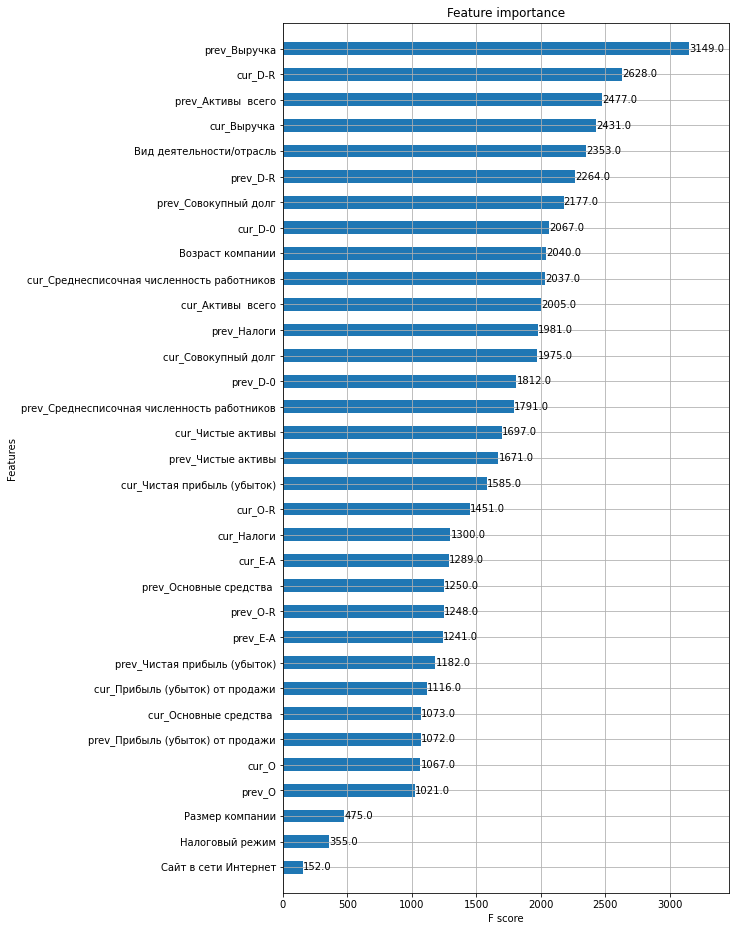

In [16]:
model = model_load()
pd.DataFrame(list(zip(X_train.columns.tolist(), \
                      model.feature_importances_.tolist())), \
             columns=['feature', 'importance'])


fig, ax = plt.subplots(1, 1, figsize=(8, 16))
xgb.plot_importance(model, max_num_features=50, height=0.5, ax=ax)


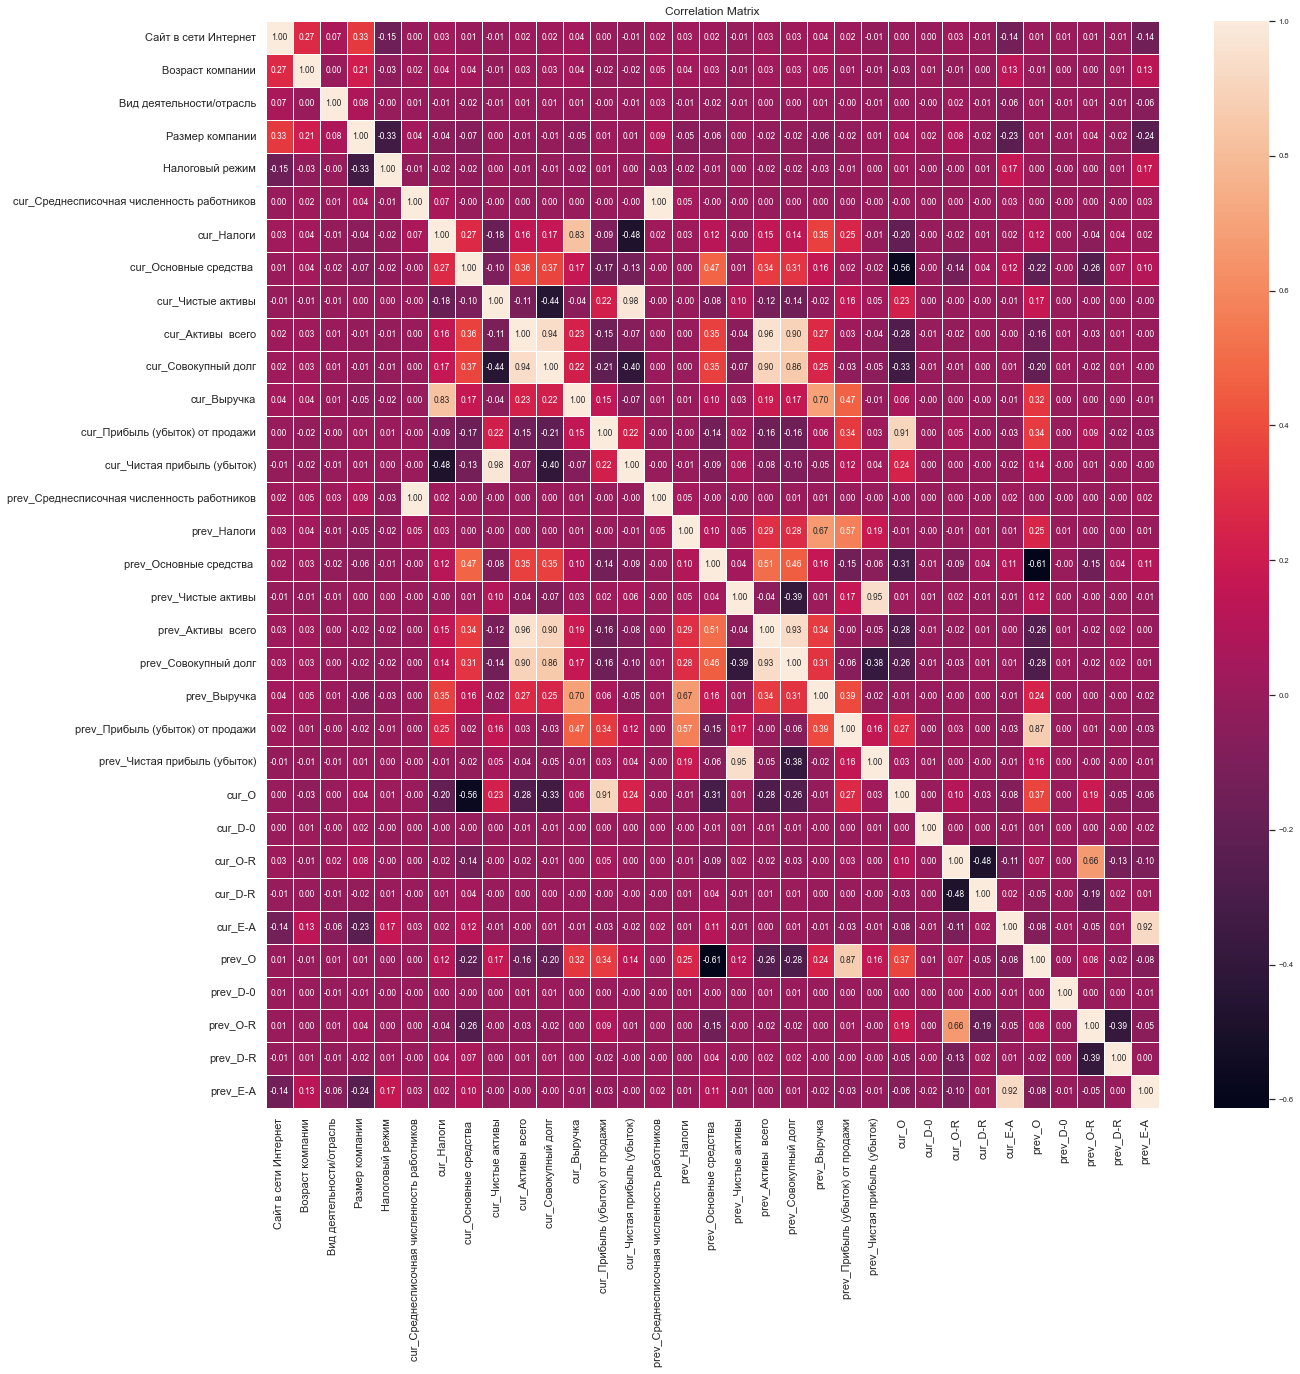

In [17]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(color_codes=True)

corr_matrix = X_train.corr()
fig, axes = plt.subplots(1, 1, figsize=(20, 20))
sns.set(font_scale=0.7)
axes.set_title("Correlation Matrix", fontsize=12)
fig = sns.heatmap(corr_matrix, annot=True, linewidths=1, fmt='.2f')
fig.get_figure().savefig('./media/cormatrix.png')

Перевод вероятностей в бинарные предсказания:

In [26]:
threshold = 0.63  # best result
binary_answers = [1 if answer > threshold else 0 for answer in answers]
# +end_src
# +begin_src python
from sklearn.metrics import r2_score

r2_score(y_test, binary_answers)

0.5809019373233546

Проверка доли верно классифицированных объектов относительно общего количества объектов

In [27]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test, binary_answers)

0.9243891194098663

Precision & recall, fscore, roc-auc, confusion matrix

Precision = 0.945
Recall    = 0.722
F-score   = 0.819
ROC_AUC   = 0.855
Log_loss  = 2.612
True_pos  = 0.722
False_pos = 0.013
True_neg  = 0.987



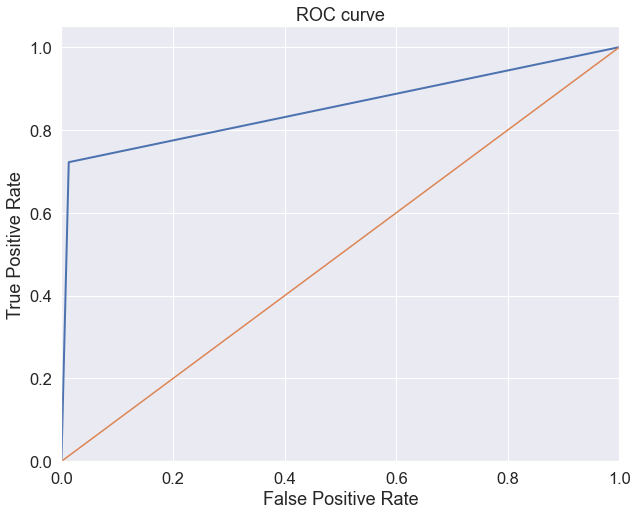

Confusion matrix, without normalization
[[4905   65]
 [ 427 1110]]


C:\Users\Buhgalter\AppData\Local\Temp\ipykernel_14072\1839829125.py:70: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


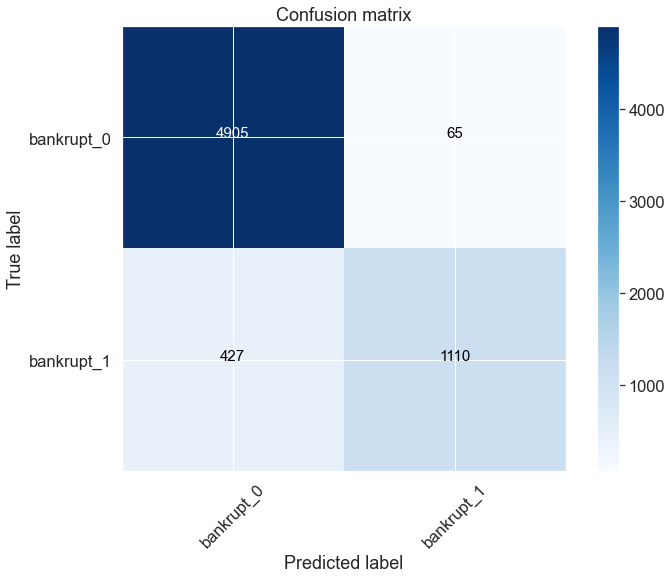

{'Precision': 0.9446808510638298,
 'Recall': 0.7221860767729343,
 'F-score': 0.8185840707964602,
 'ROC_AUC': 0.8545538029739924,
 'Log_loss': 2.611515285097437,
 'True_pos': 0.7221860767729343,
 'False_pos': 0.013078470824949699,
 'True_neg': 0.9869215291750503}

In [28]:
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, log_loss, confusion_matrix
import itertools


def get_scores(y_true,
               y_predicted,
               f_score_b=1,
               b=1,
               title='Confusion matrix',
               classes=['bankrupt_0', 'bankrupt_1'],
               normalize=False):
    """
    calculate:
    - precision
    - recall
    - fscore
    - roc-auc
    - confusion matrix
    """
    precision, recall, thresholds = precision_recall_curve(y_true, y_predicted)
    fscore = (1 + b ** 2) * (precision * recall) / (b ** 2 * precision + recall)
    # locate the index of the largest f score
    ix = np.argmax(fscore)
    roc_auc = roc_auc_score(y_true, y_predicted)
    log_loss_score = log_loss(y_true, y_predicted)

    cm = confusion_matrix(y_true, y_predicted)
    TN = cm[0][0]
    FN = cm[1][0]
    TP = cm[1][1]
    FP = cm[0][1]
    TPR = TP / (TP + FN)
    FPR = FP / (FP + TN)
    TNR = TN / (FP + TN)
    print(f'\
Precision = {precision[ix]:.3f}\n\
Recall    = {recall[ix]:.3f}\n\
F-score   = {fscore[ix]:.3f}\n\
ROC_AUC   = {roc_auc:.3f}\n\
Log_loss  = {log_loss_score:.3f}\n\
True_pos  = {TPR:.3f}\n\
False_pos = {FPR:.3f}\n\
True_neg  = {TNR:.3f}\n')

    sns.set(font_scale=1.5)
    sns.set_color_codes("muted")

    plt.figure(figsize=(10, 8))
    fpr, tpr, thresholds_ = roc_curve(y_true, y_predicted, pos_label=1)
    lw = 2
    plt.plot(fpr, tpr, lw=lw, label='ROC curve ')
    plt.plot([0, 1], [0, 1])
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.show()

    font = {'size': 15}
    plt.rc('font', **font)
    plt.figure(figsize=(10, 8))
    cmap = plt.cm.Blues
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    return {
        'Precision': precision[ix],
        'Recall': recall[ix],
        'F-score': fscore[ix],
        'ROC_AUC': roc_auc,
        'Log_loss': log_loss_score,
        'True_pos': TPR,
        'False_pos': FPR,
        'True_neg': TNR
    }


get_scores(y_test, binary_answers)